## Lab 2
### Part 2: Dealing with overfitting

Today we work with [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist) (*hint: it is available in `torchvision`*).

Your goal for today:
1. Train a FC (fully-connected) network that achieves >= 0.885 test accuracy.
2. Cause considerable overfitting by modifying the network (e.g. increasing the number of network parameters and/or layers) and demonstrate in in the appropriate way (e.g. plot loss and accurasy on train and validation set w.r.t. network complexity).
3. Try to deal with overfitting (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

__Please, write a small report describing your ideas, tries and achieved results in the end of this file.__

*Note*: Tasks 2 and 3 are interrelated, in task 3 your goal is to make the network from task 2 less prone to overfitting. Task 1 is independent from 2 and 3.

*Note 2*: We recomment to use Google Colab or other machine with GPU acceleration.

In [13]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchsummary
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import os


In [14]:
# Technical function
def mkdir(path):
    if not os.path.exists(root_path):
        os.mkdir(root_path)
        print('Directory', path, 'is created!')
    else:
        print('Directory', path, 'already exists!')

root_path = 'fmnist'
mkdir(root_path)

Directory fmnist already exists!


In [15]:
download = True
train_transform = transforms.ToTensor()
test_transform = transforms.ToTensor()
transforms.Compose((transforms.ToTensor()))


fmnist_dataset_train = torchvision.datasets.FashionMNIST(root_path,
                                                        train=True,
                                                        transform=train_transform,
                                                        target_transform=None,
                                                        download=download)
fmnist_dataset_test = torchvision.datasets.FashionMNIST(root_path,
                                                       train=False,
                                                       transform=test_transform,
                                                       target_transform=None,
                                                       download=download)

In [16]:
train_loader = torch.utils.data.DataLoader(fmnist_dataset_train,
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)
test_loader = torch.utils.data.DataLoader(fmnist_dataset_test,
                                          batch_size=256,
                                          shuffle=False,
                                          num_workers=2)

In [17]:
len(fmnist_dataset_test)

10000

In [18]:
for img, label in train_loader:
    print(f'Image shape {img.shape}')
    print(f'label shape {label.shape}')
    print(f'label sizw {label.size(0)}')
    break

Image shape torch.Size([128, 1, 28, 28])
label shape torch.Size([128])
label sizw 128


### Task 1
Train a network that achieves $\geq 0.885$ test accuracy. It's fine to use only Linear (`nn.Linear`) layers and activations/dropout/batchnorm. Convolutional layers might be a great use, but we will meet them a bit later.

In [19]:
class TinyNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(TinyNeuralNetwork, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_shape, 500),
            nn.BatchNorm1d(500),
            nn.ReLU(),
            nn.Linear(500, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Linear(100, num_classes)
            
            
        )

    def forward(self, inp):
        out = self.model(inp)
        return out

model = TinyNeuralNetwork().to('cpu')
optimizer = torch.optim.Adagrad(model.parameters(), lr=3e-3)
loss_func = nn.CrossEntropyLoss()
train_losses = []
test_losses = []
train_accs = []
test_accs = []

# Training loop
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_correct = 0

    for images, labels in train_loader:
        images = images.to('cpu')
        labels = labels.to('cpu')

        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_func(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        train_correct += (predicted == labels).sum().item()

    train_loss /= len(train_loader)
    train_accuracy = train_correct / len(fmnist_dataset_train)
    train_losses.append(train_loss)
    train_accs.append(train_accuracy)

    model.eval()
    test_correct = 0
    test_loss = 0.0
    for images, labels in test_loader:
        images = images.to('cpu')
        labels = labels.to('cpu')
        model.eval()
        with torch.no_grad():
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            loss = loss_func(outputs, labels)
            test_loss += loss.item()
            test_correct += (predicted == labels).sum().item()
            test_accuracy = test_correct / len(fmnist_dataset_test)
    test_loss /= len(test_loader)
    test_accuracy = test_correct / len(fmnist_dataset_test)
    test_losses.append(test_loss)
    test_accs.append(test_accuracy)
    

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}")


Epoch [1/10], Train Loss: 0.4756, Train Accuracy: 0.8491, Test Accuracy: 0.8576
Epoch [2/10], Train Loss: 0.3325, Train Accuracy: 0.8858, Test Accuracy: 0.8747
Epoch [3/10], Train Loss: 0.2918, Train Accuracy: 0.8985, Test Accuracy: 0.8795
Epoch [4/10], Train Loss: 0.2676, Train Accuracy: 0.9064, Test Accuracy: 0.8805
Epoch [5/10], Train Loss: 0.2462, Train Accuracy: 0.9136, Test Accuracy: 0.8862
Epoch [6/10], Train Loss: 0.2300, Train Accuracy: 0.9185, Test Accuracy: 0.8838
Epoch [7/10], Train Loss: 0.2148, Train Accuracy: 0.9250, Test Accuracy: 0.8889
Epoch [8/10], Train Loss: 0.2032, Train Accuracy: 0.9294, Test Accuracy: 0.8867
Epoch [9/10], Train Loss: 0.1910, Train Accuracy: 0.9339, Test Accuracy: 0.8896
Epoch [10/10], Train Loss: 0.1819, Train Accuracy: 0.9384, Test Accuracy: 0.8906


### Task 2: Overfit it.
Build a network that will overfit to this dataset. Demonstrate the overfitting in the appropriate way (e.g. plot loss and accurasy on train and test set w.r.t. network complexity).

*Note:* you also might decrease the size of `train` dataset to enforce the overfitting and speed up the computations.

In [20]:
class OverfittingNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(OverfittingNeuralNetwork, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_shape, 500),
            nn.BatchNorm1d(500),
            nn.ReLU(),
            nn.Linear(500, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Linear(100, num_classes) )
    def forward(self, inp):
        out = self.model(inp)
        return out

model = OverfittingNeuralNetwork().to('cpu')
optimizer = torch.optim.Adagrad(model.parameters(), lr=3e-3)
loss_func = nn.CrossEntropyLoss()
train_losses = []
test_losses = []
train_accs = []
test_accs = []

# Training loop
num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_correct = 0

    for images, labels in train_loader:
        images = images.to('cpu')
        labels = labels.to('cpu')

        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_func(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        train_correct += (predicted == labels).sum().item()

    train_loss /= len(train_loader)
    train_accuracy = train_correct / len(fmnist_dataset_train)
    train_losses.append(train_loss)
    train_accs.append(train_accuracy)

    model.eval()
    test_correct = 0
    test_loss = 0.0
    for images, labels in test_loader:
        images = images.to('cpu')
        labels = labels.to('cpu')
        model.eval()
        with torch.no_grad():
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            loss = loss_func(outputs, labels)
            test_loss += loss.item()
            test_correct += (predicted == labels).sum().item()
            test_accuracy = test_correct / len(fmnist_dataset_test)
    test_loss /= len(test_loader)
    test_accuracy = test_correct / len(fmnist_dataset_test)
    test_losses.append(test_loss)
    test_accs.append(test_accuracy)
    

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}")


Epoch [1/20], Train Loss: 0.4761, Train Accuracy: 0.8503, Test Accuracy: 0.8609
Epoch [2/20], Train Loss: 0.3340, Train Accuracy: 0.8840, Test Accuracy: 0.8624
Epoch [3/20], Train Loss: 0.2938, Train Accuracy: 0.8975, Test Accuracy: 0.8790
Epoch [4/20], Train Loss: 0.2676, Train Accuracy: 0.9059, Test Accuracy: 0.8832
Epoch [5/20], Train Loss: 0.2461, Train Accuracy: 0.9134, Test Accuracy: 0.8849
Epoch [6/20], Train Loss: 0.2310, Train Accuracy: 0.9193, Test Accuracy: 0.8776
Epoch [7/20], Train Loss: 0.2163, Train Accuracy: 0.9241, Test Accuracy: 0.8851
Epoch [8/20], Train Loss: 0.2034, Train Accuracy: 0.9291, Test Accuracy: 0.8867
Epoch [9/20], Train Loss: 0.1919, Train Accuracy: 0.9346, Test Accuracy: 0.8800
Epoch [10/20], Train Loss: 0.1825, Train Accuracy: 0.9374, Test Accuracy: 0.8880
Epoch [11/20], Train Loss: 0.1720, Train Accuracy: 0.9416, Test Accuracy: 0.8961
Epoch [12/20], Train Loss: 0.1640, Train Accuracy: 0.9448, Test Accuracy: 0.8910
Epoch [13/20], Train Loss: 0.1551, Tr

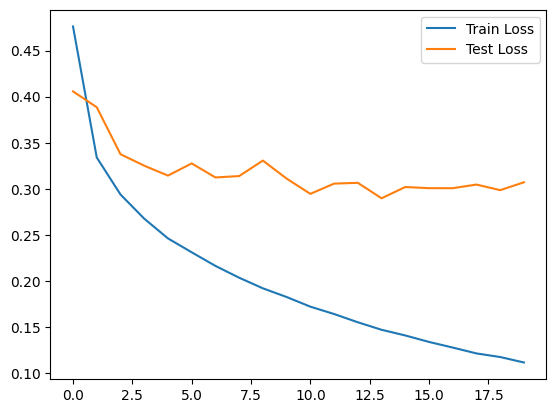

In [21]:
plt.plot(train_losses)
plt.plot(test_losses)
plt.legend(['Train Loss', 'Test Loss'])

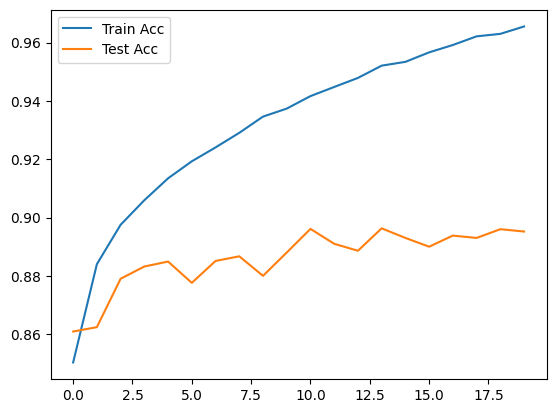

In [22]:
plt.plot(train_accs)
plt.plot(test_accs)
plt.legend(['Train Acc', 'Test Acc'])

# Вывод.
Улучшения нет, скорее всего, мы переобучили.

### Task 3: Fix it.
Fix the overfitted network from the previous step (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

In [23]:
class FixedNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(FixedNeuralNetwork, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_shape, 500),
            nn.BatchNorm1d(500),
            nn.Dropout(0.6),
            nn.ReLU(),
            nn.Linear(500, 100),
            nn.BatchNorm1d(100),
            nn.Dropout(0.6),
            nn.ReLU(),
            nn.Linear(100, num_classes) )
    def forward(self, inp):
        out = self.model(inp)
        return out

model = FixedNeuralNetwork().to('cpu')
optimizer = torch.optim.Adagrad(model.parameters(), lr=3e-3)
loss_func = nn.CrossEntropyLoss()
train_losses = []
test_losses = []
train_accs = []
test_accs = []

# Training loop
num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_correct = 0

    for images, labels in train_loader:
        images = images.to('cpu')
        labels = labels.to('cpu')

        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_func(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        train_correct += (predicted == labels).sum().item()

    train_loss /= len(train_loader)
    train_accuracy = train_correct / len(fmnist_dataset_train)
    train_losses.append(train_loss)
    train_accs.append(train_accuracy)

    model.eval()
    test_correct = 0
    test_loss = 0.0
    for images, labels in test_loader:
        images = images.to('cpu')
        labels = labels.to('cpu')
        model.eval()
        with torch.no_grad():
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            loss = loss_func(outputs, labels)
            test_loss += loss.item()
            test_correct += (predicted == labels).sum().item()
            test_accuracy = test_correct / len(fmnist_dataset_test)
    test_loss /= len(test_loader)
    test_accuracy = test_correct / len(fmnist_dataset_test)
    test_losses.append(test_loss)
    test_accs.append(test_accuracy)
    

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}")


Epoch [1/20], Train Loss: 0.7515, Train Accuracy: 0.7718, Test Accuracy: 0.8307
Epoch [2/20], Train Loss: 0.5629, Train Accuracy: 0.8198, Test Accuracy: 0.8434
Epoch [3/20], Train Loss: 0.5151, Train Accuracy: 0.8328, Test Accuracy: 0.8492
Epoch [4/20], Train Loss: 0.4915, Train Accuracy: 0.8371, Test Accuracy: 0.8547
Epoch [5/20], Train Loss: 0.4787, Train Accuracy: 0.8415, Test Accuracy: 0.8576
Epoch [6/20], Train Loss: 0.4586, Train Accuracy: 0.8476, Test Accuracy: 0.8601
Epoch [7/20], Train Loss: 0.4500, Train Accuracy: 0.8483, Test Accuracy: 0.8614
Epoch [8/20], Train Loss: 0.4400, Train Accuracy: 0.8527, Test Accuracy: 0.8630
Epoch [9/20], Train Loss: 0.4315, Train Accuracy: 0.8540, Test Accuracy: 0.8626
Epoch [10/20], Train Loss: 0.4276, Train Accuracy: 0.8564, Test Accuracy: 0.8654
Epoch [11/20], Train Loss: 0.4174, Train Accuracy: 0.8590, Test Accuracy: 0.8666
Epoch [12/20], Train Loss: 0.4163, Train Accuracy: 0.8599, Test Accuracy: 0.8678
Epoch [13/20], Train Loss: 0.4087, Tr

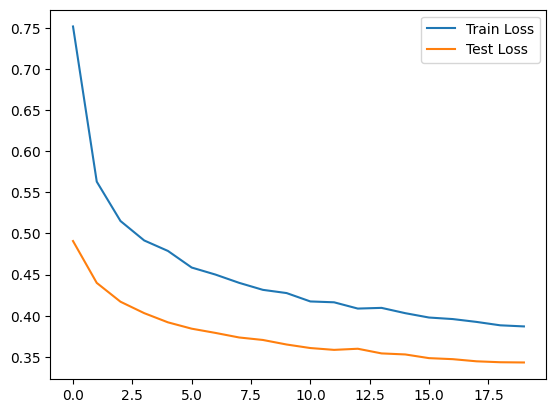

In [24]:
plt.plot(train_losses)
plt.plot(test_losses)
plt.legend(['Train Loss', 'Test Loss'])

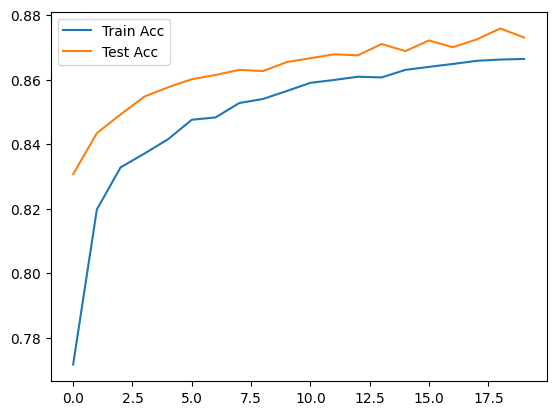

In [25]:
plt.plot(train_accs)
plt.plot(test_accs)
plt.legend(['Train Acc', 'Test Acc'])

### Conclusions:
Получили решение лишенное недостатка в виде переобучения.